##### **Importing Libraries:**

In [3]:
import requests
from bs4 import BeautifulSoup
import csv, json
from urllib.parse import urljoin
import pandas as pd
import re 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

##### **Data Extraction:**

In [34]:
base_url = 'https://books.toscrape.com'
page_url = 'https://books.toscrape.com/catalogue/page-{}.html'

In [35]:
rating_map = {
    'One': 1,
    'Two': 2,
    'Three': 3,
    'Four': 4,
    'Five': 5
}

booksData = []

for page in range(1, 51):
    
    print(f'Scraping page-{page}...')
    
    if page == 1:
        url = base_url
    else:
        url = page_url.format(page)
        

    res = requests.get(url)
    soup = BeautifulSoup(res.text, 'html.parser')

    for book in soup.select('article.product_pod'):
        title = book.h3.a['title']
        price = book.select_one('.price_color').text
        availability = book.select_one('.availability').text.strip()

        rating_class = book.select_one('p.star-rating')['class']
        star_word = [cls for cls in rating_class if cls != 'star-rating'][0]
        stars = rating_map.get(star_word, 0)

        relative_link = book.h3.a['href']
        if 'catalogue/' not in relative_link:
            relative_link = 'catalogue/' + relative_link
        book_url = urljoin(base_url, relative_link)

        detail_res = requests.get(book_url)
        detail_soup = BeautifulSoup(detail_res.text, 'html.parser')

        desc_tag = detail_soup.select_one('#product_description ~ p')
        description = desc_tag.text.strip() if desc_tag else None

        table = detail_soup.select_one('table.table.table-striped')
        info = {row.th.text: row.td.text for row in table.select('tr')} if table else None
        upc = info.get('UPC', '') if info else None


        genre_tags = detail_soup.select('ul.breadcrumb li > a')
        
        genre_tag = genre_tags[2].text.strip() if len(genre_tags) > 2 else None


        booksData.append({
            'title': title,
            'price': price,
            'availability': availability,
            'stars': stars,
            'url': book_url,
            'description': description,
            'upc': upc,
            'genre': genre_tag,
        })

Scraping page-1...
Scraping page-2...
Scraping page-3...
Scraping page-4...
Scraping page-5...
Scraping page-6...
Scraping page-7...
Scraping page-8...
Scraping page-9...
Scraping page-10...
Scraping page-11...
Scraping page-12...
Scraping page-13...
Scraping page-14...
Scraping page-15...
Scraping page-16...
Scraping page-17...
Scraping page-18...
Scraping page-19...
Scraping page-20...
Scraping page-21...
Scraping page-22...
Scraping page-23...
Scraping page-24...
Scraping page-25...
Scraping page-26...
Scraping page-27...
Scraping page-28...
Scraping page-29...
Scraping page-30...
Scraping page-31...
Scraping page-32...
Scraping page-33...
Scraping page-34...
Scraping page-35...
Scraping page-36...
Scraping page-37...
Scraping page-38...
Scraping page-39...
Scraping page-40...
Scraping page-41...
Scraping page-42...
Scraping page-43...
Scraping page-44...
Scraping page-45...
Scraping page-46...
Scraping page-47...
Scraping page-48...
Scraping page-49...
Scraping page-50...


##### **Saving raw data:**

In [36]:
with open('books_raw.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.DictWriter(f, fieldnames=booksData[0].keys())
    writer.writeheader()
    writer.writerows(booksData)

In [37]:
with open('books_raw.json', 'w', encoding='utf-8') as f:
    json.dump(booksData, f, indent=4, ensure_ascii=False)

##### **Data Cleaning & Processing:**

In [4]:
df = pd.read_csv('books_raw.csv')

df.sample(10)

,title,price,availability,stars,url,description,upc,genre
702,Very Good Lives: The Fringe Benefits of Failur...,Â£50.66,In stock,3,https://books.toscrape.com/catalogue/very-good...,"In 2008, J.K. Rowling delivered a deeply affec...",52aa3d79b1cee455,Nonfiction
462,Proofs of God: Classical Arguments from Tertul...,Â£54.21,In stock,1,https://books.toscrape.com/catalogue/proofs-of...,Leading theologian Matthew Levering presents a...,d56d0710668bb39c,Philosophy
381,Furiously Happy: A Funny Book About Horrible T...,Â£41.46,In stock,4,https://books.toscrape.com/catalogue/furiously...,"In LET'S PRETEND THIS NEVER HAPPENED, Jenny La...",c6a29d6df8de968c,Nonfiction
498,The Year of Living Biblically: One Man's Humbl...,Â£34.72,In stock,1,https://books.toscrape.com/catalogue/the-year-...,"From the bestselling author of ""The Know-It-Al...",4a0b78598b42897a,Default
380,Hide Away (Eve Duncan #20),Â£11.84,In stock,1,https://books.toscrape.com/catalogue/hide-away...,Iris Johansen's beloved forensic sculptor Eve ...,bddc6fd036eb6279,Mystery
693,Wuthering Heights,Â£17.73,In stock,3,https://books.toscrape.com/catalogue/wuthering...,"Wuthering Heights is a wild, passionate story ...",5a7ff9aaa3168878,Classics
748,The Goldfinch,Â£43.58,In stock,3,https://books.toscrape.com/catalogue/the-goldf...,"It begins with a boy. Theo Decker, a thirteen-...",c88422d8959260ab,Default
904,Where Lightning Strikes (Bleeding Stars #3),Â£39.77,In stock,3,https://books.toscrape.com/catalogue/where-lig...,Do you know what it feels like right before li...,def389ddfda6991b,Romance
641,A Girl's Guide to Moving On (New Beginnings #2),Â£31.30,In stock,1,https://books.toscrape.com/catalogue/a-girls-g...,NEW YORK TIMES BESTSELLER â¢ In this powerful...,cf3b86489890b9f2,Romance
102,I am a Hero Omnibus Volume 1,Â£54.63,In stock,3,https://books.toscrape.com/catalogue/i-am-a-he...,The zombie apocalypse has never been more surr...,1c89ae5bb804e4de,Sequential Art


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         1000 non-null   object
 1   price         1000 non-null   object
 2   availability  1000 non-null   object
 3   stars         1000 non-null   int64 
 4   url           1000 non-null   object
 5   description   998 non-null    object
 6   upc           1000 non-null   object
 7   genre         1000 non-null   object
dtypes: int64(1), object(7)
memory usage: 62.6+ KB


In [5]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 998 entries, 0 to 999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         998 non-null    object
 1   price         998 non-null    object
 2   availability  998 non-null    object
 3   stars         998 non-null    int64 
 4   url           998 non-null    object
 5   description   998 non-null    object
 6   upc           998 non-null    object
 7   genre         998 non-null    object
dtypes: int64(1), object(7)
memory usage: 70.2+ KB


In [41]:
df.duplicated().sum()

np.int64(0)

In [6]:
df['price'] = df['price'].apply(lambda x: re.sub(r'Â£','', x))
df.head()

,title,price,availability,stars,url,description,upc,genre
0,A Light in the Attic,51.77,In stock,3,https://books.toscrape.com/catalogue/a-light-i...,It's hard to imagine a world without A Light i...,a897fe39b1053632,Poetry
1,Tipping the Velvet,53.74,In stock,1,https://books.toscrape.com/catalogue/tipping-t...,"""Erotic and absorbing...Written with starling ...",90fa61229261140a,Historical Fiction
2,Soumission,50.10,In stock,1,https://books.toscrape.com/catalogue/soumissio...,"Dans une France assez proche de la nÃ´tre, un ...",6957f44c3847a760,Fiction
3,Sharp Objects,47.82,In stock,4,https://books.toscrape.com/catalogue/sharp-obj...,"WICKED above her hipbone, GIRL across her hear...",e00eb4fd7b871a48,Mystery
4,Sapiens: A Brief History of Humankind,54.23,In stock,5,https://books.toscrape.com/catalogue/sapiens-a...,From a renowned historian comes a groundbreaki...,4165285e1663650f,History


In [7]:
#fix dtype for price col
df['price']=df['price'].astype('float')
df.dtypes

title            object
price           float64
availability     object
stars             int64
url              object
description      object
upc              object
genre            object
dtype: object

In [8]:
#We are making sure the URL is correct using regex
matches=df.url.apply(lambda x: bool(re.match(r'https://books.toscrape.com/catalogue/[\w-]+/index.html',x)))
df=df[matches]
df.head()

,title,price,availability,stars,url,description,upc,genre
0,A Light in the Attic,51.77,In stock,3,https://books.toscrape.com/catalogue/a-light-i...,It's hard to imagine a world without A Light i...,a897fe39b1053632,Poetry
1,Tipping the Velvet,53.74,In stock,1,https://books.toscrape.com/catalogue/tipping-t...,"""Erotic and absorbing...Written with starling ...",90fa61229261140a,Historical Fiction
2,Soumission,50.10,In stock,1,https://books.toscrape.com/catalogue/soumissio...,"Dans une France assez proche de la nÃ´tre, un ...",6957f44c3847a760,Fiction
3,Sharp Objects,47.82,In stock,4,https://books.toscrape.com/catalogue/sharp-obj...,"WICKED above her hipbone, GIRL across her hear...",e00eb4fd7b871a48,Mystery
4,Sapiens: A Brief History of Humankind,54.23,In stock,5,https://books.toscrape.com/catalogue/sapiens-a...,From a renowned historian comes a groundbreaki...,4165285e1663650f,History


##### **Saving clean data:**

In [45]:
df.to_csv('books_clean.csv', index=False, encoding='utf-8')

In [46]:
df.to_json('books_clean.json', orient='records', indent=4)

##### **Data Analysis and Visualization:**

In [47]:
data=df.groupby('genre')['stars'].mean().round()
df.genre.unique()

array(['Poetry', 'Historical Fiction', 'Fiction', 'Mystery', 'History',
       'Young Adult', 'Business', 'Default', 'Sequential Art', 'Music',
       'Science Fiction', 'Politics', 'Travel', 'Thriller',
       'Food and Drink', 'Romance', 'Childrens', 'Nonfiction', 'Art',
       'Spirituality', 'Philosophy', 'New Adult', 'Contemporary',
       'Fantasy', 'Add a comment', 'Science', 'Health', 'Horror',
       'Self Help', 'Religion', 'Christian', 'Crime', 'Autobiography',
       'Christian Fiction', 'Biography', 'Womens Fiction', 'Erotica',
       'Cultural', 'Psychology', 'Humor', 'Historical', 'Novels',
       'Short Stories', 'Suspense', 'Classics', 'Academic',
       'Sports and Games', 'Adult Fiction', 'Parenting', 'Paranormal'],
      dtype=object)

C:\Users\CAVO\AppData\Local\Temp\ipykernel_2840\3852918838.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=data.index,x=data.values,palette='viridis')


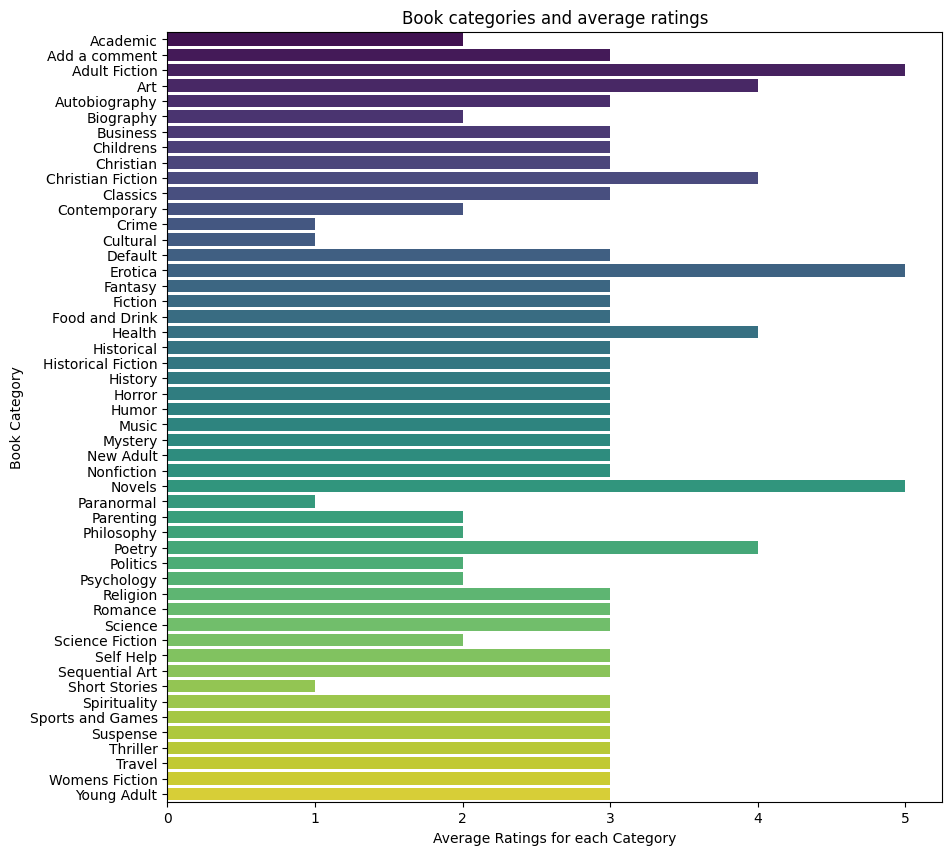

In [48]:
plt.figure(figsize=(10,10))
sns.barplot(y=data.index,x=data.values,palette='viridis')
plt.ylabel('Book Category')
plt.xlabel('Average Ratings for each Category')
plt.title('Book categories and average ratings')
plt.show()

In [9]:
grouped_data_avg=df.groupby('genre')['price'].mean().reset_index()
df2=grouped_data_avg
df2.head()

,genre,price
0,Academic,13.120000
1,Add a comment,35.796418
2,Adult Fiction,15.360000
3,Art,38.520000
4,Autobiography,37.053333


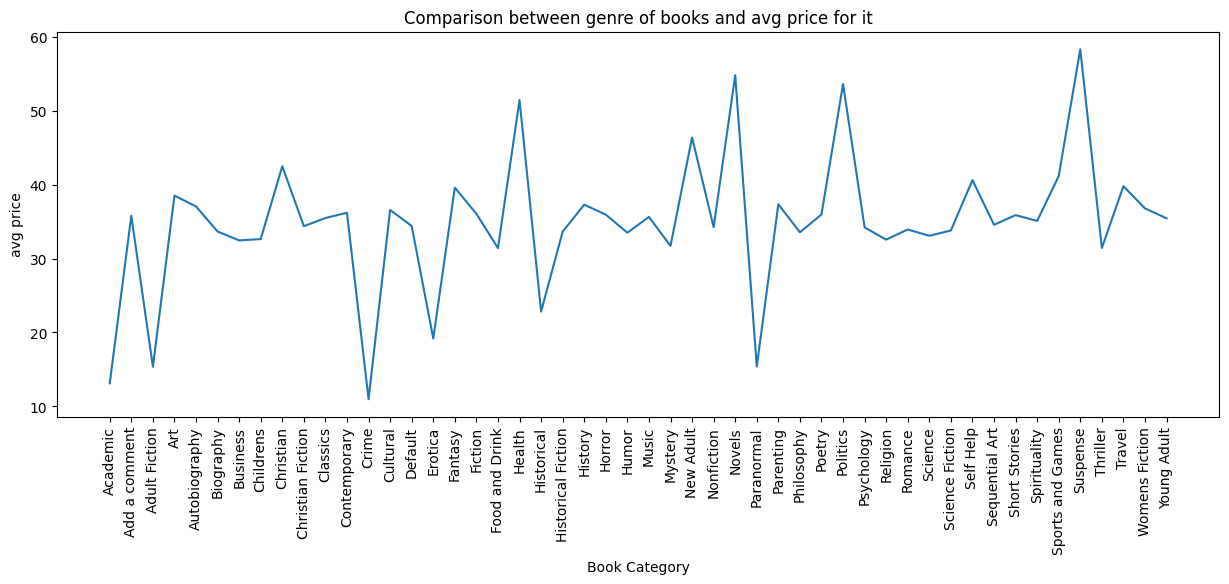

In [10]:
plt.figure(figsize=(15,5))
plt.plot(df2.genre,df2.price)
plt.xticks(rotation=90)
plt.xlabel('Book Category')
plt.ylabel('avg price')
plt.title('Comparison between genre of books and avg price for it')
plt.show()

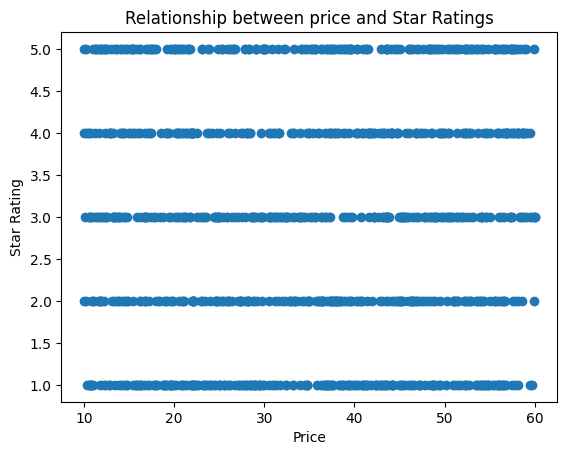

In [ ]:
plt.scatter(df.price,df.stars)
plt.title('Relationship between Price and Star Ratings')
plt.xlabel('Price')
plt.ylabel('Star Rating')
plt.show()

A plot showing no relationship between book price and ratings.

In [50]:
categories=df.genre.value_counts().reset_index()
categories=categories.sort_values(by='count', ascending=False).head(10)
categories

,genre,count
0,Default,151
1,Nonfiction,110
2,Sequential Art,75
3,Add a comment,67
4,Fiction,65
5,Young Adult,54
6,Fantasy,48
7,Romance,35
8,Mystery,32
9,Food and Drink,30


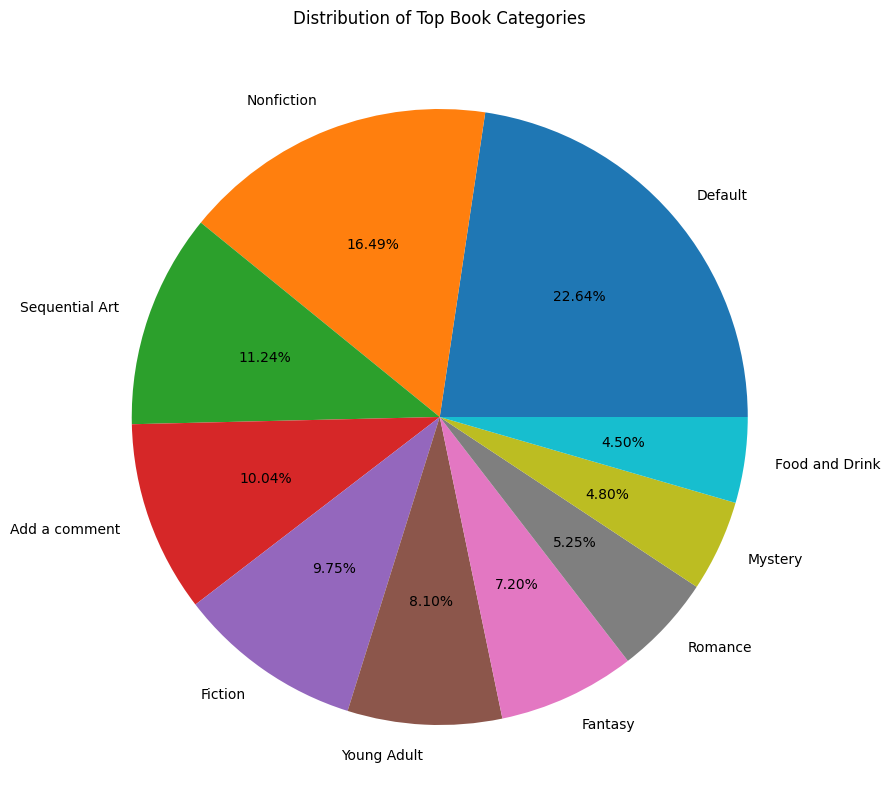

In [51]:
plt.figure(figsize=(10,10))
plt.pie(categories['count'],labels=categories['genre'],autopct='%0.2f%%')
plt.title('Distribution of Top Book Categories')
plt.show()

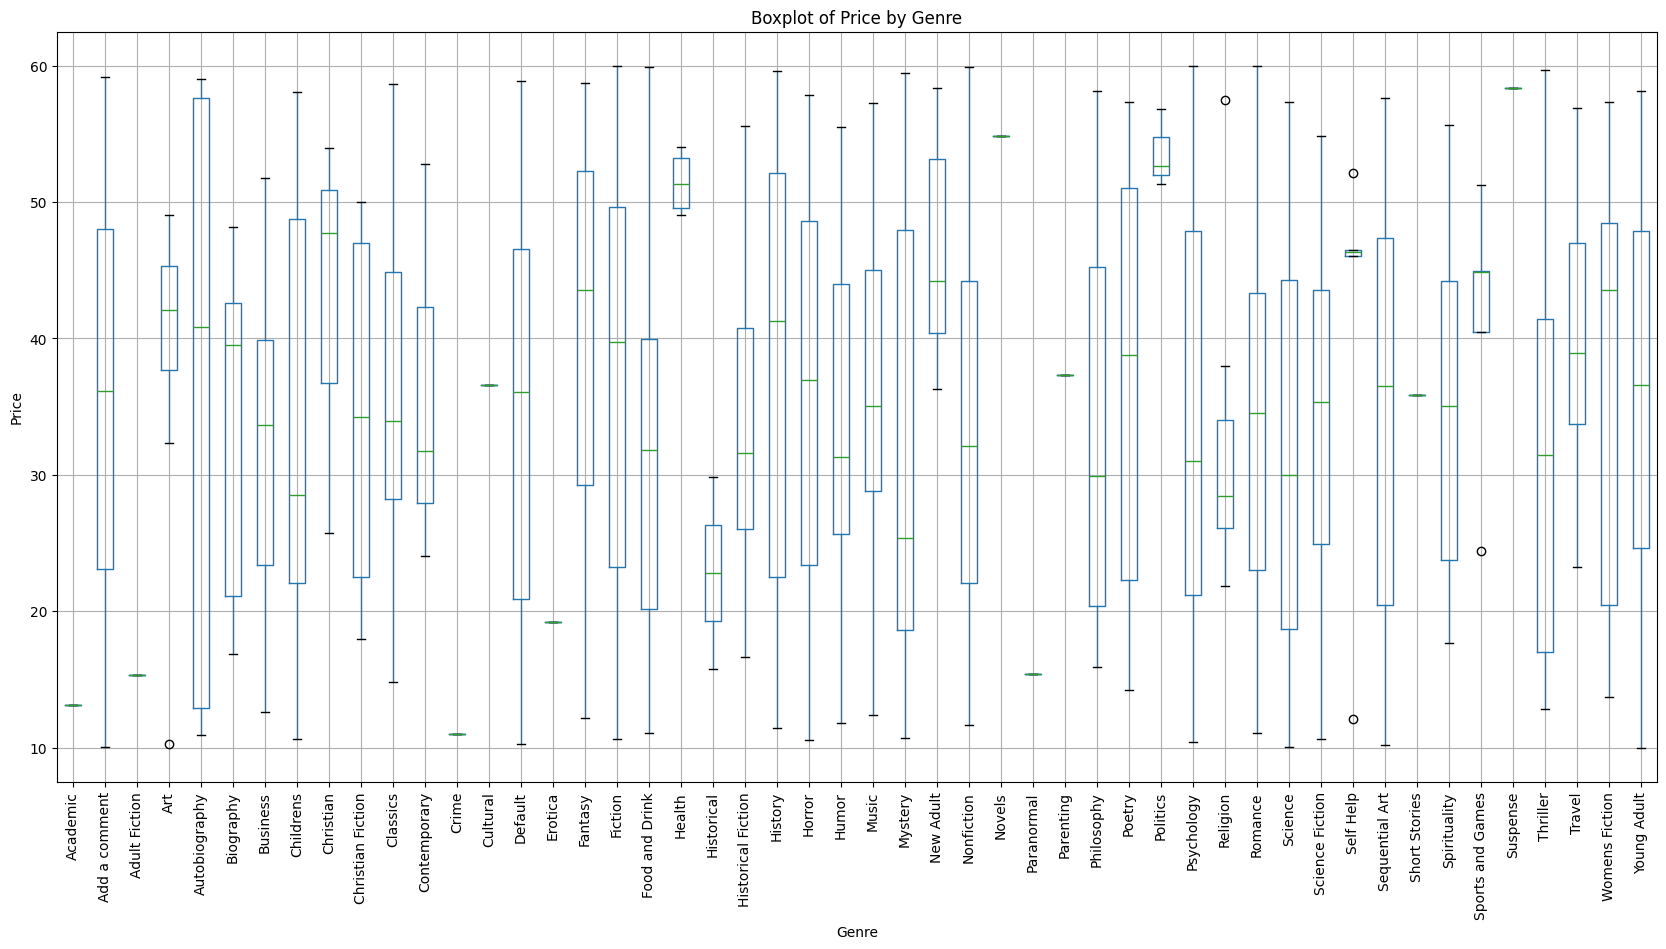

In [52]:
data = df[['genre', 'price']]

fig, ax = plt.subplots(figsize=(20, 10))
data.boxplot(by='genre', rot=90, ax=ax)

ax.set_title('Boxplot of Price by Genre')
plt.suptitle('')
ax.set_xlabel('Genre')
ax.set_ylabel('Price')

plt.show()

In [53]:
#visualize word cloud for sequentil art descreption and see the most frequent words in this genre
art_description=df[df['genre']=='Sequential Art']
art_description.sample(6)

,title,price,availability,stars,url,description,upc,genre
270,Robin War,47.82,In stock,3,https://books.toscrape.com/catalogue/robin-war...,Itâs Robins vs. cops! Robins vs. Robins! Rob...,85b2176b3b194030,Sequential Art
53,This One Summer,19.49,In stock,4,https://books.toscrape.com/catalogue/this-one-...,"Every summer, Rose goes with her mom and dad t...",51653ef291ab7ddc,Sequential Art
228,Through the Woods,25.38,In stock,2,https://books.toscrape.com/catalogue/through-t...,'It came from the woods. Most strange things d...,6e44bcbeac7f4360,Sequential Art
575,"Death Note, Vol. 6: Give-and-Take (Death Note #6)",36.39,In stock,3,https://books.toscrape.com/catalogue/death-not...,Light Yagami is an ace student with great pros...,6e06d0f00f6da20f,Sequential Art
194,"Fables, Vol. 1: Legends in Exile (Fables #1)",41.62,In stock,4,https://books.toscrape.com/catalogue/fables-vo...,When a savage creature known only as the Adver...,65d034adf80834b7,Sequential Art
222,"We Are Robin, Vol. 1: The Vigilante Business (...",53.90,In stock,1,https://books.toscrape.com/catalogue/we-are-ro...,The teenagers of Gotham City have adopted the ...,92275cedf6d8ee15,Sequential Art


In [54]:
art_description_text=' '.join(art_description['description'])
art_description_text

'Scott Pilgrim\'s life is totally sweet. He\'s 23 years old, he\'s in a rockband, he\'s "between jobs" and he\'s dating a cute high school girl. Nothing could possibly go wrong, unless a seriously mind-blowing, dangerously fashionable, rollerblading delivery girl named Ramona Flowers starts cruising through his dreams and sailing by him at parties. Will Scott\'s awesome life get Scott Pilgrim\'s life is totally sweet. He\'s 23 years old, he\'s in a rockband, he\'s "between jobs" and he\'s dating a cute high school girl. Nothing could possibly go wrong, unless a seriously mind-blowing, dangerously fashionable, rollerblading delivery girl named Ramona Flowers starts cruising through his dreams and sailing by him at parties. Will Scott\'s awesome life get turned upside-down? Will he have to face Ramona\'s seven evil ex-boyfriends in battle? The short answer is yes. The long answer is Scott Pilgrim, Volume 1: Scott Pilgrim\'s Precious Little Life ...more DUAL WORLDS, DUAL SIGHTS In the lan

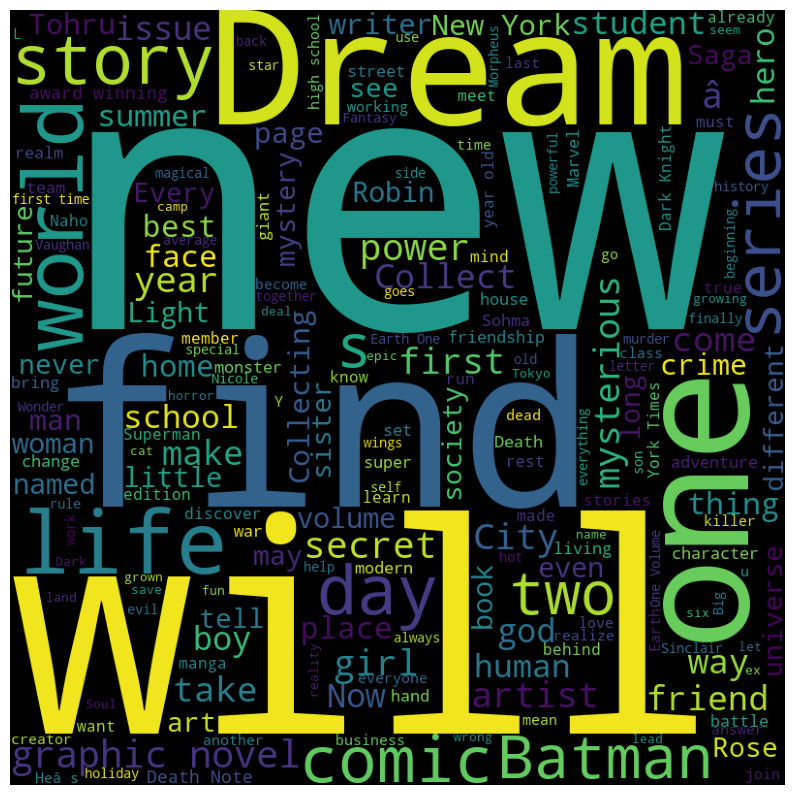

In [55]:
word=WordCloud(width=800,height=800).generate(art_description_text)
plt.figure(figsize=(10,15))
plt.imshow(word)
plt.axis('off')
plt.show()

##### **Saving data in MongoDB:**

In [12]:
#import lib which deal with mongoDB through python
from pymongo import MongoClient

In [13]:
#connect to mongoDB
client=MongoClient('mongodb://localhost:27017')
#create data base('My_Data_Base')
DB=client['My_Data_Base']
#create a collection in ('My_Data_Base') it's like table in SQL but here it saves data as a documents
Documents=DB['book_doc']

we need to convert DataFrame to list of dictionary each dict represents record or document to save it in mongoDB

In [14]:
list_of_dict=df.to_dict('records')
list_of_dict

[{'title': 'A Light in the Attic',
  'price': 51.77,
  'availability': 'In stock',
  'stars': 3,
  'url': 'https://books.toscrape.com/catalogue/a-light-in-the-attic_1000/index.html',
  'description': "It's hard to imagine a world without A Light in the Attic. This now-classic collection of poetry and drawings from Shel Silverstein celebrates its 20th anniversary with this special edition. Silverstein's humorous and creative verse can amuse the dowdiest of readers. Lemon-faced adults and fidgety kids sit still and read these rhythmic words and laugh and smile and love th It's hard to imagine a world without A Light in the Attic. This now-classic collection of poetry and drawings from Shel Silverstein celebrates its 20th anniversary with this special edition. Silverstein's humorous and creative verse can amuse the dowdiest of readers. Lemon-faced adults and fidgety kids sit still and read these rhythmic words and laugh and smile and love that Silverstein. Need proof of his genius? Rockab

In [15]:
#insert data in mongoDB
Documents.insert_many(list_of_dict)
#it autmatically assigns an id for each document

InsertManyResult([ObjectId('6807bd6c3936371da5c57050'), ObjectId('6807bd6c3936371da5c57051'), ObjectId('6807bd6c3936371da5c57052'), ObjectId('6807bd6c3936371da5c57053'), ObjectId('6807bd6c3936371da5c57054'), ObjectId('6807bd6c3936371da5c57055'), ObjectId('6807bd6c3936371da5c57056'), ObjectId('6807bd6c3936371da5c57057'), ObjectId('6807bd6c3936371da5c57058'), ObjectId('6807bd6c3936371da5c57059'), ObjectId('6807bd6c3936371da5c5705a'), ObjectId('6807bd6c3936371da5c5705b'), ObjectId('6807bd6c3936371da5c5705c'), ObjectId('6807bd6c3936371da5c5705d'), ObjectId('6807bd6c3936371da5c5705e'), ObjectId('6807bd6c3936371da5c5705f'), ObjectId('6807bd6c3936371da5c57060'), ObjectId('6807bd6c3936371da5c57061'), ObjectId('6807bd6c3936371da5c57062'), ObjectId('6807bd6c3936371da5c57063'), ObjectId('6807bd6c3936371da5c57064'), ObjectId('6807bd6c3936371da5c57065'), ObjectId('6807bd6c3936371da5c57066'), ObjectId('6807bd6c3936371da5c57067'), ObjectId('6807bd6c3936371da5c57068'), ObjectId('6807bd6c3936371da5c570

In [16]:
#for retrive data we use find funcion
retrevied_data=list(Documents.find())

In [17]:
retrevied_data=pd.DataFrame(retrevied_data)
retrevied_data.head()

,_id,title,price,availability,stars,url,description,upc,genre
0,6807bd6c3936371da5c57050,A Light in the Attic,51.77,In stock,3,https://books.toscrape.com/catalogue/a-light-i...,It's hard to imagine a world without A Light i...,a897fe39b1053632,Poetry
1,6807bd6c3936371da5c57051,Tipping the Velvet,53.74,In stock,1,https://books.toscrape.com/catalogue/tipping-t...,"""Erotic and absorbing...Written with starling ...",90fa61229261140a,Historical Fiction
2,6807bd6c3936371da5c57052,Soumission,50.10,In stock,1,https://books.toscrape.com/catalogue/soumissio...,"Dans une France assez proche de la nÃ´tre, un ...",6957f44c3847a760,Fiction
3,6807bd6c3936371da5c57053,Sharp Objects,47.82,In stock,4,https://books.toscrape.com/catalogue/sharp-obj...,"WICKED above her hipbone, GIRL across her hear...",e00eb4fd7b871a48,Mystery
4,6807bd6c3936371da5c57054,Sapiens: A Brief History of Humankind,54.23,In stock,5,https://books.toscrape.com/catalogue/sapiens-a...,From a renowned historian comes a groundbreaki...,4165285e1663650f,History
